In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import pickle

torch.manual_seed(1)

## Loading the datasets, i.e loading frames for few actions

In [2]:
#loading and prepping data
dtd_sub = np.load('./NTU_skedata_standard/xsub/train_data.npy')
dvd_sub = np.load('./NTU_skedata_standard/xsub/val_data.npy')
pf1 = open("./NTU_skedata_standard/xsub/train_label.pkl","rb")
pf2 = open("./NTU_skedata_standard/xsub/val_label.pkl","rb")
dtl_sub = pickle.load(pf1)
dvl_sub = pickle.load(pf2)

print('Number of training samples : ', len(dtl_sub[1]))
print('Number of validation samples : ', len(dvl_sub[1]))

Number of training samples :  40091
Number of validation samples :  16487


## Some utility functions to split the datasets and loading the datasets in batch

In [3]:
def myformat(X):
    X = X[:,:,:,:,0]
    print('X shape : ', X.shape)
    Xx, Xy, Xz = X[:,0,:,:], X[:,1,:,:], X[:,2,:,:]
    print('Xx sahpe : ', Xx.shape)
    print('Xy sahpe : ', Xy.shape)
    print('Xz sahpe : ', Xz.shape)
    print('now doing root centering ...')
    Xx = Xx-Xx[:,:,0,None]
    Xy = Xy-Xy[:,:,0,None]
    Xz = Xz-Xz[:,:,0,None]
    X = np.concatenate((Xx,Xy,Xz), axis=2)
    print('X shape : ', X.shape)
    return X

In [4]:
dtd_sub = myformat(dtd_sub)
dvd_sub = myformat(dvd_sub)

X shape :  (40091, 3, 300, 25)
Xx sahpe :  (40091, 300, 25)
Xy sahpe :  (40091, 300, 25)
Xz sahpe :  (40091, 300, 25)
now doing root centering ...
X shape :  (40091, 300, 75)
X shape :  (16487, 3, 300, 25)
Xx sahpe :  (16487, 300, 25)
Xy sahpe :  (16487, 300, 25)
Xz sahpe :  (16487, 300, 25)
now doing root centering ...
X shape :  (16487, 300, 75)


In [6]:
SEQ_LEN = None
def Data_gen(train_split, labels, SEQ_LEN):
    N = len(labels)
    idx = [i for i in range(N)]
    while(True):
        X = train_split
        databatch_id = random.sample(idx, 1)[0]
        databatch = list(train_split)[databatch_id]
        databatch, label = databatch, labels[databatch_id]
        if SEQ_LEN is not None:
            if len(databatch) > SEQ_LEN:
                databatch = databatch[0:SEQ_LEN]
            elif len(databatch) < SEQ_LEN:
                databatch = np.concatenate((databatch, np.zeros((SEQ_LEN - len(databatch), 75))))
            else:
                pass
            yield databatch,label
        else:
            yield databatch,label

ACTd = Data_gen(dtd_sub, dtl_sub[1], SEQ_LEN)
ACTvd = Data_gen(dvd_sub, dvl_sub[1], SEQ_LEN)

# next(ACTd)
print('Data_gens enstansiated')

(array([[ 0.        , -0.00310034, -0.00961411, ..., -0.25617003,
         -0.2790451 , -0.29252696],
        [ 0.        ,  0.00876918,  0.00719348, ..., -0.26221991,
         -0.29881692, -0.3120501 ],
        [ 0.        ,  0.03569901,  0.04567397, ..., -0.24928093,
         -0.28728008, -0.30156708],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32), 9)

## LSTM Classifier model defination and intialisation

In [7]:
#action LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, joints_dim, hidden_dim, label_size, batch_size, num_layers, kernel_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        joints_dim2d = joints_dim - 25
        
        self.lstm3 = nn.LSTM(joints_dim, hidden_dim, num_layers=self.num_layers)
        self.conv1_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
        self.lstm2_1 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_1 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_2 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_2 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_3 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
#         self.conv1_1 = nn.Conv1d(4, 2, kernel_size, stride=1, padding=1) #for kernel size=3
#         self.conv1_2 = nn.Conv1d(2, 1, kernel_size, stride=1, padding=1) #for kernel size=3
        
        self.hidden3 = self.init_hidden3()
        self.hidden2_1 = self.init_hidden2_1()
        self.hidden2_2 = self.init_hidden2_2()
        self.hidden2_3 = self.init_hidden2_3()
        
        self.hidden2label = nn.Linear(hidden_dim, label_size)
    
    def init_hidden3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_1(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_2(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    
    
    def forward(self, joints3d_vec):
        x3 = joints3d_vec
        x2 = x3.view(-1, 25, 3)
        x2_1 = x2[:,:,1:3].contiguous().view(-1, 1, 50)
        x2_2 = x2[:,:,0:2].contiguous().view(-1, 1, 50)
        x2_3 = x2[:,:,[0,2]].contiguous().view(-1, 1, 50)
#         print('x2_3 : ',x2_3.size())
        lstm_out3, self.hidden3 = self.lstm3(x3, self.hidden3)
        lstm_out2_1, self.hidden2_1 = self.lstm2_1(x2_1, self.hidden2_1)
        lstm_out2_2, self.hidden2_2 = self.lstm2_2(x2_2, self.hidden2_2)
        lstm_out2_3, self.hidden2_3 = self.lstm2_3(x2_3, self.hidden2_3)
#         print('lstm_out[-1] : ', lstm_out[-1].size())
        t3 = lstm_out3[-1].view(self.batch_size,1,-1)
#         print('t3 : ', t3.size())
        t2_1 = lstm_out2_1[-1].view(self.batch_size,1,-1)
        t2_2 = lstm_out2_2[-1].view(self.batch_size,1,-1)
        t2_3 = lstm_out2_3[-1].view(self.batch_size,1,-1)
        
        y3 = self.conv1_3(t3)
#         print('y3 : ', y3.size())
        y2_1 = self.conv1_2_1(t2_1)
#         print('y2_1 : ', y2_1.size())
        y2_2 = self.conv1_2_2(t2_2)
#         print('y2_2 : ', y2_2.size())
        y2_3 = self.conv1_2_3(t2_3)
#         print('y2_3 : ', y2_3.size())
        
        y3 += y2_1+y2_2+y2_3
        
        y3 = y3.contiguous().view(-1, self.hidden_dim)
#         print('y3 : ', y3.size())
        y  = self.hidden2label(y3)
        log_probs = F.log_softmax(y, dim=1)
        return log_probs
#instanstiating a model
model0 = LSTMClassifier(75, 512, 60, 1, 2, 3)
#to do stuff in CUDA
model0 = model0.cuda()
print(model0)

## Training the model

In [18]:
def evaluate_stocha_val_acc(model):
    model.eval()
    acc_cum = 0
    N = dvd_sub.shape[0]
    for i in range(N):
        X = dvd_sub[i, :, :]
        X = autograd.Variable(torch.from_numpy(X).float().cuda())
        X = X.view(len(X), 1, -1)
        y_pred = model(X)
        y_pred = y_pred.data.cpu().max(1)[1].numpy()[0]
        if y_pred == dvl_sub[1][i]:
            acc_cum += 1
    return acc_cum*100/N

## observations
* better to use the log_softmax instead of softmax
* decrease lr succicesively to get better results

In [19]:
#training function
def train(model, num_epoch, num_iter, rec_interval, disp_interval):
    optimizer = optim.Adam(model.parameters(), lr = 1e-6)
    loss_values = []
    avg_loss_values = []
    rec_step = 0
    print('Starting the training ...')
    for eph in range(num_epoch):
        print('epoch {} starting ...'.format(eph))
        avg_loss = 0
        n_samples = 0
        model.train()
        for i in range(num_iter):
            model.hidden3 = (model.hidden3[0].detach(), model.hidden3[1].detach())
            model.hidden2_1 = (model.hidden2_1[0].detach(), model.hidden2_1[1].detach())
            model.hidden2_2 = (model.hidden2_2[0].detach(), model.hidden2_2[1].detach())
            model.hidden2_3 = (model.hidden2_3[0].detach(), model.hidden2_3[1].detach())
            model.zero_grad()
            X,Y = next(ACTd)
            n_samples += len(X)
            X = autograd.Variable(torch.from_numpy(X).float().cuda())
            X = X.view(len(X), 1, -1)
            Y = autograd.Variable(torch.LongTensor(np.array([Y])).cuda())

            y_hat = model(X)
#             print(eph, i, y_hat)
            loss = F.cross_entropy(y_hat, Y)
            avg_loss += loss.data[0]
            
            if i % disp_interval == 0:
                print('epoch: %d iterations: %d loss :%g' % (eph, i, loss.data[0]))
            if rec_step%rec_interval==0:
                loss_values.append(loss.data[0])
            
            loss.backward()     
            optimizer.step()
            rec_step += 1
            
        avg_loss /= n_samples
        avg_loss_values.append(avg_loss)
        #evaluating model accuracy
        acc = evaluate_stocha_val_acc(model)
        print('epoch: {} <====train track===> avg_loss: {}, accuracy: {}% \n'.format(eph, avg_loss, acc))
    return loss_values, avg_loss_values


loss_vals, avg_loss_vals = train(model0, 3, 100, 2, 10) #100eph_8e-6, 
# plt.figure()
# plt.plot(loss_vals)
# plt.figure()
# plt.plot(avg_loss_vals)
# plt.xlabel('epoch')
# plt.ylabel('avg loss')
pickle_out = open('loss_avg_loss.pkl', 'wb')
pickle.dump((loss_vals, avg_loss_vals), pickle_out)
pickle_out.close()

Starting the training ...
epoch 0 starting ...
epoch: 0 iterations: 0 loss :4.31123
epoch: 0 iterations: 10 loss :3.97292
epoch: 0 iterations: 20 loss :4.71648
epoch: 0 iterations: 30 loss :4.08534
epoch: 0 iterations: 40 loss :3.63926
epoch: 0 iterations: 50 loss :4.14366
epoch: 0 iterations: 60 loss :4.22622
epoch: 0 iterations: 70 loss :4.3187
epoch: 0 iterations: 80 loss :3.83437
epoch: 0 iterations: 90 loss :3.60053


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1513366702650/work/torch/lib/THC/generic/THCStorage.cu:58

In [29]:
avg_loss_v1 = avg_loss_vals

In [32]:
avg_loss_v1 += avg_loss_vals

Text(0,0.5,'avg loss')

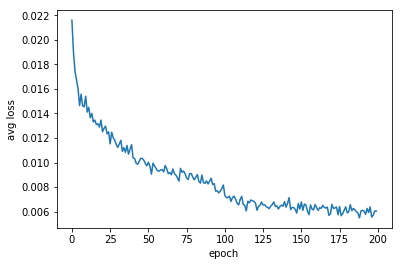

In [33]:
plt.plot(avg_loss_v1)
plt.xlabel('epoch')
plt.ylabel('avg loss')

In [34]:
# saving the model
def save_model(model_name, path, model):
    p = path+'/'+model_name
    print('saving at {}'.format(p))
    torch.save(model.state_dict(), p)
    print('saved at {}'.format(p))

In [35]:
save_model('LSTMClassifierX3_c7.pth', './checkpoints', model0)

saving at ./checkpoints/LSTMClassifierX3_c7.pth
saved at ./checkpoints/LSTMClassifierX3_c7.pth


In [36]:
mtest = LSTMClassifier(75, 512, 7, 1, 2, 3).cuda()
mtest.load_state_dict(torch.load('./checkpoints/LSTMClassifierX3_c7.pth'))

In [38]:
mtest.lstm3.weight_hh_l0

Parameter containing:
 3.9143e-02  2.4818e-02  3.2468e-02  ...   8.5511e-03 -1.7184e-02 -3.2849e-02
-1.3644e-02 -4.0704e-02  3.7073e-02  ...  -3.0386e-02 -2.2615e-02 -4.2696e-02
-2.8556e-02 -3.3357e-03  3.7336e-02  ...   5.2892e-03 -1.9198e-02  3.0822e-02
                ...                   ⋱                   ...                
-2.1083e-02  3.5893e-02 -1.1259e-03  ...   2.0177e-02  3.5760e-02  3.1273e-02
 5.1477e-03 -2.0578e-02  4.1886e-02  ...  -1.3133e-02  2.3866e-02 -2.6527e-02
-2.6014e-04  9.1317e-03  2.4725e-03  ...   2.3441e-02  1.9406e-02  1.0368e-02
[torch.cuda.FloatTensor of size 2048x512 (GPU 0)]